# Demo of bmtool chemical synaptic tuner using BMTK network
by Gregory Glickert

For a bit more context in using the tuner you can check out the notebook called neuron_chem_syn_tuner which goes over more details about using the tuner with pure NEURON models.

When running this tuner you will see some warnings. That is on purpose, some of the synapses in this bmtk testing network do not have the Dep, Fac or Use parameters. That is ok and the tuner will still work for those synapses, but you can't tune those parameteres since they dont exist in the mod file.



In [1]:
from bmtool.synapses import SynapseTuner

tuner = SynapseTuner(
    config='bmtk_files/simulation_config.json',  # Path to BMTK config
    current_name='i',                            # Synaptic current to record
    slider_vars=['initW','Dep','Fac','Use','tau1','tau2']  # Parameters for sliders
)


--No graphics will be displayed.


loading /home/gjgpb9/BMTK-test-net/bmtool/docs/examples/notebooks/synapses/synaptic_tuner/bmtk_files/components/templates/cell_templates.hoc
loading /home/gjgpb9/BMTK-test-net/bmtool/docs/examples/notebooks/synapses/synaptic_tuner/bmtk_files/components/templates/templates_V1.hoc
Building conn_type_settings from BMTK config files...
Found 8 connection types: ['Exc2PV', 'SOM2PV', 'PV2PV', 'Exc2SOM', 'Exc2Exc', 'SOM2Exc', 'PV2Exc', 'background_syn']
No connection specified, using first available: Exc2PV
Error accessing 'Dep' in syn Exp2Syn[0]: 'hoc.HocObject' object has no attribute 'Dep'
Error accessing 'Fac' in syn Exp2Syn[1]: 'hoc.HocObject' object has no attribute 'Fac'
Error accessing 'Use' in syn Exp2Syn[2]: 'hoc.HocObject' object has no attribute 'Use'


When using the tuner with multiple networks you can switch between your different bmtk networks to test every single connection in your network. Note the synaptic weight (sometimes called initW) is the bmtk netconn weight. If you are tuning a synapse for its strenth make sure to keep this in mind. You should be able to convert that to a scale factor for you weight inside the mod file if needed

In [2]:
tuner.InteractiveTuner()

Output()

If using the optimizer with a bmtk network just make sure you specifiy which connection you want to use. You can switch it in the Interactive tuner or using the switch_connection method

In [3]:
tuner._switch_connection('PV2Exc')

Successfully switched to connection: PV2Exc


Now we tune that PV2Exc synapse

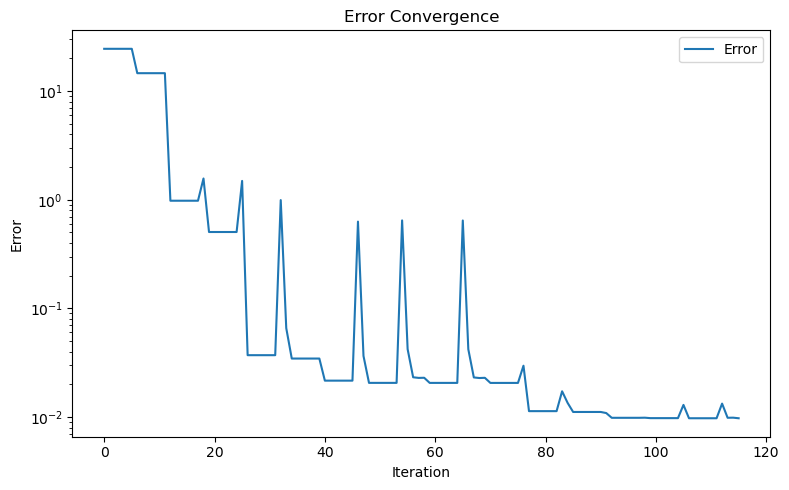

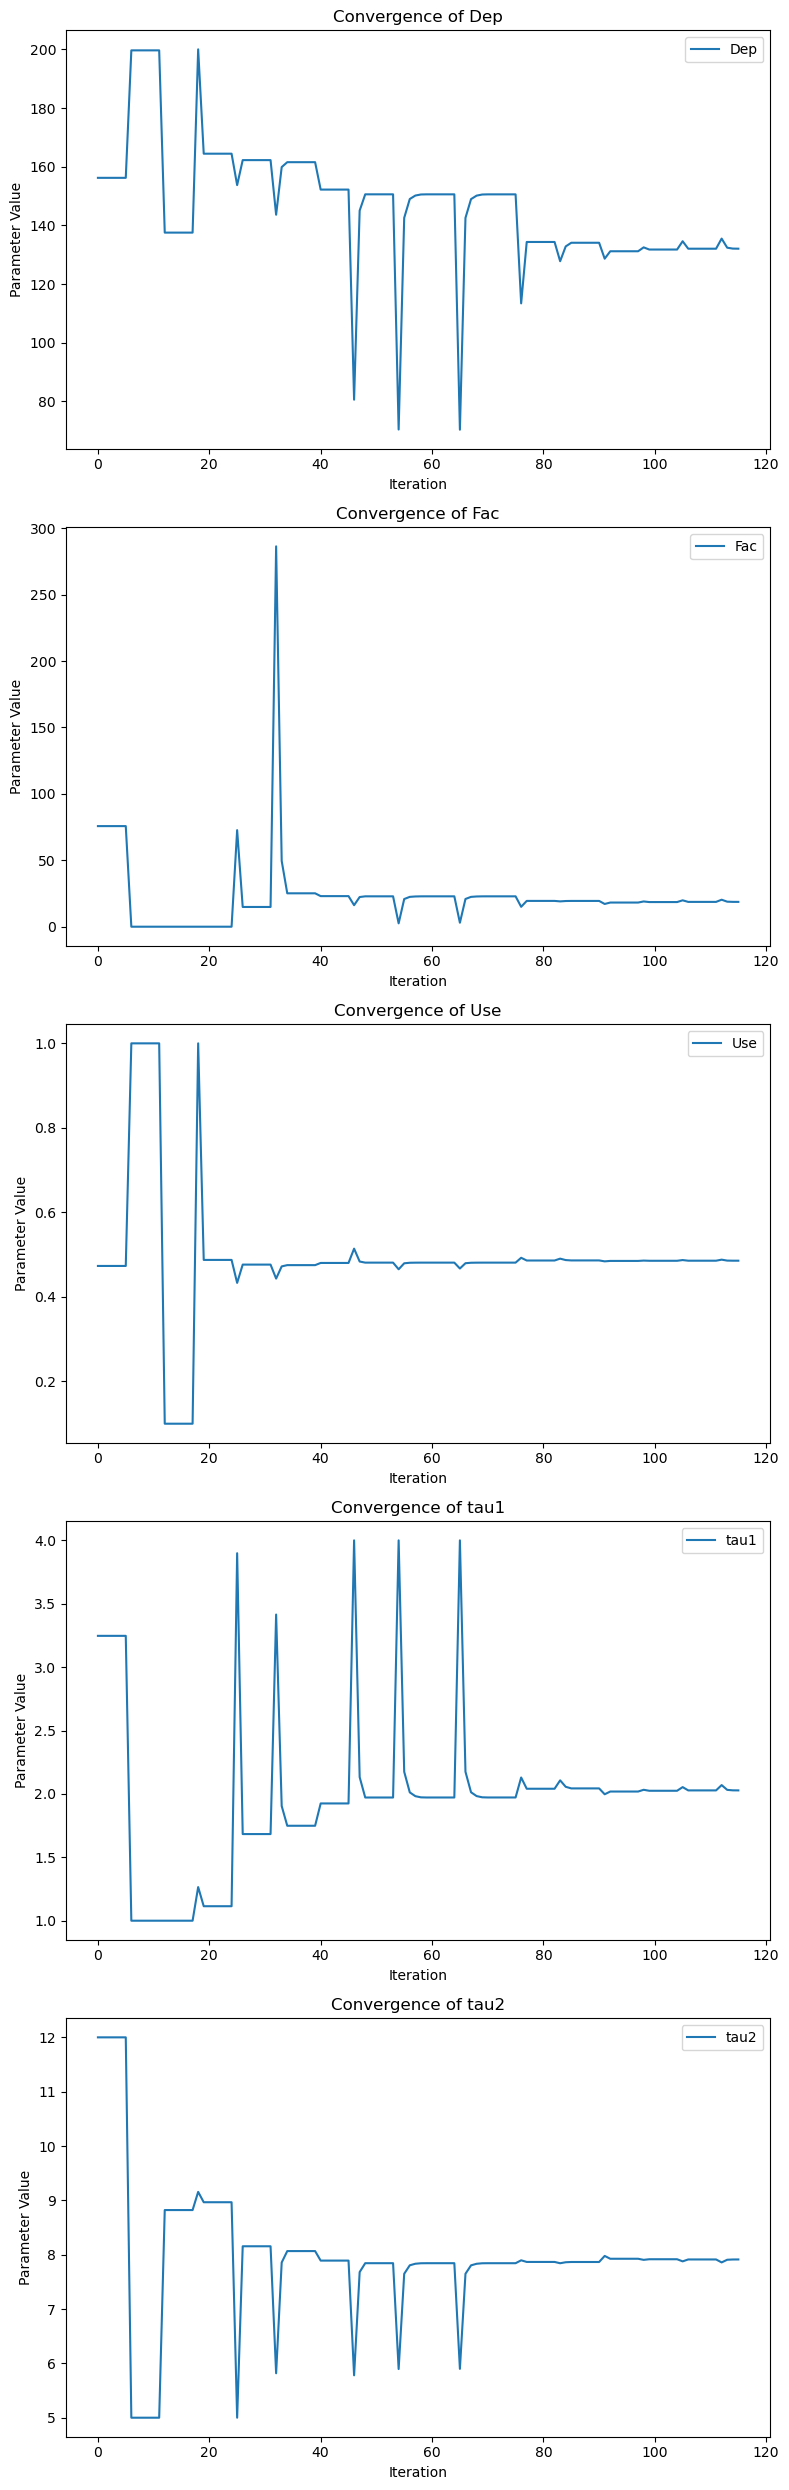

Optimization Results:
Final Error: 9.74e-03

Target Metrics:
induction: -0.700 (target: -0.750)
ppr: 0.795 (target: 0.800)
recovery: -0.068 (target: 0.000)
max_amplitude: 0.243 (target: 25.000)
rise_time: 2.050 (target: 2.000)
decay_time: 9.000 (target: 9.000)

Optimal Parameters:
Dep: 132.061
Fac: 18.686
Use: 0.486
tau1: 2.028
tau2: 7.913


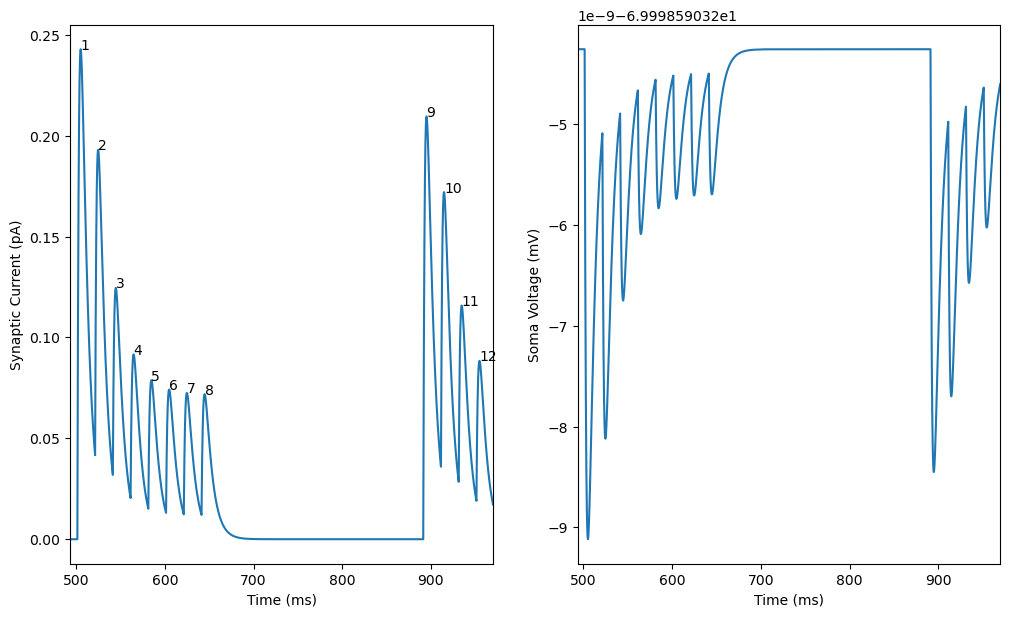


Short Term Plasticity Results for 50Hz with 250 Delay
PPR: Above 1 is facilitating, below 1 is depressing.
Induction: Above 0 is facilitating, below 0 is depressing.
Recovery: A measure of how fast STP decays.

Paired Pulse Response (PPR)
Calculation: 2nd pulse / 1st pulse
Values: ([[0.19]]) / ([[0.24]]) = [[0.79]]

Induction
Calculation: (avg(6th, 7th, 8th pulses) - 1st pulse) / max amps
Values: avg([[0.07, 0.07, 0.07]]) - [[0.24]] / [0.24]
([0.07]) - ([0.24]) / [0.24] = -0.700

Recovery
Calculation: (avg(9th, 10th, 11th, 12th pulses) - avg(1st to 4th pulses)) / max amps
Values: avg([[0.21, 0.17, 0.12, 0.09]]) - avg([[0.24, 0.19, 0.12, 0.09]]) / [0.24]
([0.15]) - ([0.16]) / [0.24] = -0.068




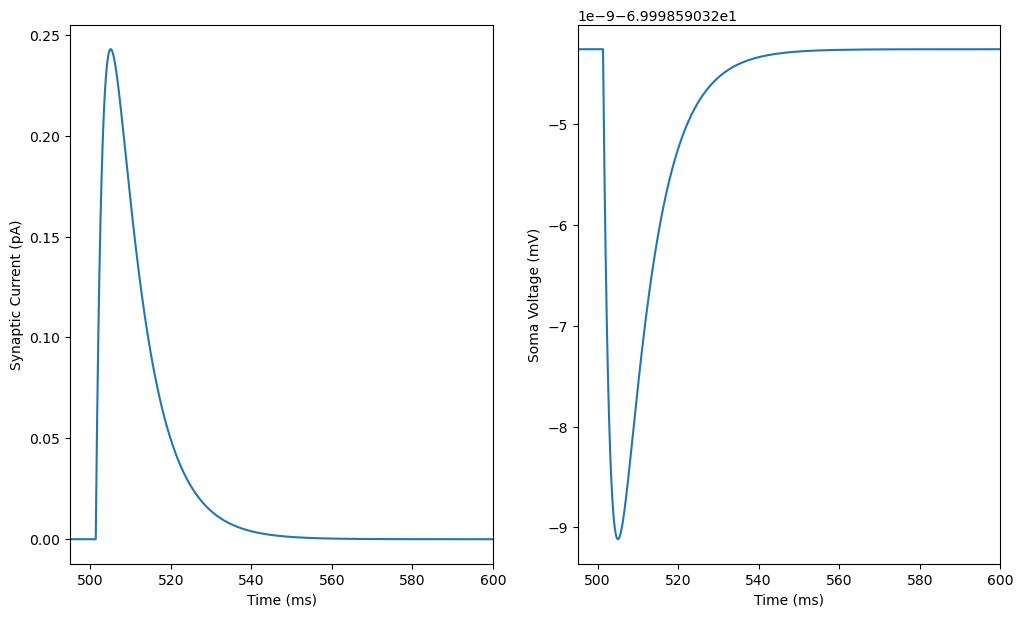

('baseline', 0.0)
('sign', 1.0)
('latency', 1.35)
('amp', 0.0002428663192964911)
('rise_time', 2.0500000000000003)
('decay_time', 8.999801595557695)
('half_width', 11.925)
Current Integral in pA*ms: 3.07


In [4]:
from bmtool.synapses import SynapseOptimizer

# Create the optimizer
optimizer = SynapseOptimizer(tuner)

# Define parameter bounds these can be any range variable you wish to tune
param_bounds = {
    'Dep': (0, 200.0),
    'Fac': (0, 400.0),
    'Use': (0.1, 1.0),
    'tau1': (1,4), # tau r needs to be less than tau d so be careful
    'tau2': (5,20)
}

# Define target metrics these are the metrics that the tuner will try to automatic get the synapse to respond with
# max amps is an absolute value
target_metrics = {
    'induction': -0.75,
    'ppr': 0.8,
    'recovery': 0.0,
    'rise_time': 2,          # This wont always be the case, but for this synapse Use controls STP and max amps so it can sometimes struggle to fit.
    'decay_time': 9
}

# currently the only metrics in the SynapseOptimizer are 
#            - induction: measure of synaptic facilitation/depression
#            - ppr: paired-pulse ratio
#            - recovery: recovery from facilitation/depression
#            - max_amplitude: maximum synaptic response amplitude
#            - rise_time: time for synaptic response to rise from 20% to 80% of peak
#            - decay_time: time constant of synaptic response decay
#            - latency: synaptic response latency
#            - half_width: synaptic response half-width
#            - baseline: baseline current
#            - amp: peak amplitude from syn_props
def custom_cost(metrics, targets):
    # equal zero unless using train input
    induction_error = (metrics['induction'] - targets['induction']) ** 2
    ppr_error = (metrics['ppr'] - targets['ppr']) ** 2
    recovery_error = (metrics['recovery'] - targets['recovery']) ** 2
    max_amp_errror = (metrics['max_amplitude'] - targets['max_amplitude']) ** 2
    # equal zero unless using SingleEvent
    rise_time_error = (metrics['rise_time'] - targets['rise_time']) ** 2
    decay_time_error = (metrics['decay_time'] - targets['decay_time']) ** 2 

    #return rise_time_error + decay_time_error
    return induction_error + 3 * ppr_error + recovery_error + rise_time_error + decay_time_error #+ 0.5*max_amp_errror

# Run optimization with custom cost function
result = optimizer.optimize_parameters(
    target_metrics=target_metrics,
    param_bounds=param_bounds,
    run_single_event=True,  # Run and use parameters from SingleEvent
    run_train_input=True,   # Run and use parameters from train input 
    train_frequency=50,     # Freq in Hz of train input
    train_delay=250,        # delay in ms of second train
    init_guess='random',    # either random or middle_guess. Random will start the synapse witha random value in the param_bound. Middle guess will pick the middle value in the param_bounds
    cost_function=custom_cost,
    method='SLSQP'          # I believe this will be the fastest method, but you may try others check out https://docs.scipy.org/doc/scipy-1.15.0/reference/generated/scipy.optimize.minimize.html
                            # SLSQP is a gradient based method while nelder-mead is simplex (whatever that means)
)

# Plot results
optimizer.plot_optimization_results(result)